# Capstone Project

### Import required libraries

In [1]:
import numpy as np
#in case we need to repeat experiment
np.random.seed(255)

import pandas as pd
pd.options.display.max_rows = 22

import matplotlib.pyplot as plt
plt.style.use('classic')


import seaborn as sns
sns.set()

%matplotlib inline
%precision 3

'%.3f'

### Read data file

In [2]:
#df = pd.read_csv('NCDB_2016.csv', engine = 'python')
df = pd.read_csv('NCDB_1999_to_2016.csv', engine = 'python')

In [3]:
print(df.shape)

(6486831, 23)


In [4]:
print(df.head(2))

   C_YEAR C_MNTH C_WDAY C_HOUR  C_SEV C_VEHS C_CONF C_RCFG C_WTHR C_RSUR  \
0    1999     01      1     20      2     02     34     UU      1      5   
1    1999     01      1     20      2     02     34     UU      1      5   

   ...   V_TYPE V_YEAR P_ID P_SEX P_AGE P_PSN P_ISEV P_SAFE P_USER C_CASE  
0  ...       06   1990   01     M    41    11      1     UU      1    752  
1  ...       01   1987   01     M    19    11      1     UU      1    752  

[2 rows x 23 columns]


In [5]:
print(df.loc[0:4])

   C_YEAR C_MNTH C_WDAY C_HOUR  C_SEV C_VEHS C_CONF C_RCFG C_WTHR C_RSUR  \
0    1999     01      1     20      2     02     34     UU      1      5   
1    1999     01      1     20      2     02     34     UU      1      5   
2    1999     01      1     20      2     02     34     UU      1      5   
3    1999     01      1     08      2     01     01     UU      5      3   
4    1999     01      1     08      2     01     01     UU      5      3   

   ...   V_TYPE V_YEAR P_ID P_SEX P_AGE P_PSN P_ISEV P_SAFE P_USER C_CASE  
0  ...       06   1990   01     M    41    11      1     UU      1    752  
1  ...       01   1987   01     M    19    11      1     UU      1    752  
2  ...       01   1987   02     F    20    13      2     02      2    752  
3  ...       01   1986   01     M    46    11      1     UU      1    753  
4  ...       NN   NNNN   01     M    05    99      2     UU      3    753  

[5 rows x 23 columns]


In [6]:
df.dtypes

C_YEAR     int64
C_MNTH    object
C_WDAY    object
C_HOUR    object
C_SEV      int64
C_VEHS    object
C_CONF    object
C_RCFG    object
C_WTHR    object
C_RSUR    object
C_RALN    object
           ...  
V_ID      object
V_TYPE    object
V_YEAR    object
P_ID      object
P_SEX     object
P_AGE     object
P_PSN     object
P_ISEV    object
P_SAFE    object
P_USER    object
C_CASE     int64
Length: 23, dtype: object

In [7]:
#Move the dependent variable to the outside and drop C_CASE column
P_ISEV = df['P_ISEV']
P_ISEV
df.drop(columns = ['P_ISEV', 'C_SEV', 'C_CASE'], inplace = True)
df['P_ISEV'] = P_ISEV
df


,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_SAFE,P_USER,P_ISEV
0,1999,01,1,20,02,34,UU,1,5,3,...,01,06,1990,01,M,41,11,UU,1,1
1,1999,01,1,20,02,34,UU,1,5,3,...,02,01,1987,01,M,19,11,UU,1,1
2,1999,01,1,20,02,34,UU,1,5,3,...,02,01,1987,02,F,20,13,02,2,2
3,1999,01,1,08,01,01,UU,5,3,6,...,01,01,1986,01,M,46,11,UU,1,1
4,1999,01,1,08,01,01,UU,5,3,6,...,99,NN,NNNN,01,M,05,99,UU,3,2
5,1999,01,1,17,03,QQ,QQ,1,2,1,...,01,01,1984,01,M,28,11,UU,1,1
6,1999,01,1,17,03,QQ,QQ,1,2,1,...,02,01,1991,01,M,21,11,UU,1,1
7,1999,01,1,17,03,QQ,QQ,1,2,1,...,02,01,1991,02,F,UU,13,UU,2,2
8,1999,01,1,17,03,QQ,QQ,1,2,1,...,03,01,1992,01,M,UU,11,UU,1,2
9,1999,01,1,15,01,04,UU,1,5,U,...,01,01,1997,01,M,61,11,UU,1,1


### Check for missing values

In [8]:
print("This dataset has {0} missing value".format(df.isnull().sum().sum()))
print("This dataset has {0} NA value".format(df.isna().sum().sum()))

This dataset has 0 missing value
This dataset has 0 NA value


### Prepare the dependent variable.  Drop all unkown values in the dependent column P_ISEV
#### Drop rows containing N, U, X, NA, and NULL

In [9]:
df['P_ISEV'].isin(['U', 'N', 'X' ]).sum()

417421

In [10]:
drop_count = df['P_ISEV'].isin(['U', 'N', 'X' ]).sum()
df.drop(df.index[df['P_ISEV'].isin(['U', 'N', 'X' ])], inplace=True)
df = df.reset_index(drop=True)
print("Dropped {drop_count} rows from dataset".format(drop_count = drop_count))

Dropped 417421 rows from dataset


In [11]:
#Check for non-numeric values in P_ISEV column
count = df['P_ISEV'].str.contains('[^0-9]').sum()
print("{count} non-numeric rows observed".format(count = count))

0 non-numeric rows observed


In [12]:
### drop rows that have more than 4 missing values and P_ISEV is not fatal
missing_value_strings = ['U', 'UU', 'UUU', 'UUUU', 'N', 'NN', 'NNN', 'NNNN', 'Q', 'QQ', 'QQQ', 'QQQQ', 'X', 'XX', 'XXX', 'XXXX']
non_fatal_with_more_than_4_missing = ((df.isin(missing_value_strings).sum(axis=1) > 3) & ~(df['P_ISEV'] == '3')).sum()
df.drop(df.index[(df.isin(missing_value_strings).sum(axis=1) > 3) & ~(df['P_ISEV'] == '3')], inplace = True)
df = df.reset_index(drop=True)
print("Dropped {drop_count} rows from dataset".format(drop_count = non_fatal_with_more_than_4_missing))

Dropped 238608 rows from dataset


In [13]:
df.shape

(5830802, 21)

### Clean intividual attributes

In [14]:
#### Clean Accident Year column

#Collisions by Year
print("{count} non-numeric rows observed".format(count = df['C_YEAR'].astype('str').str.contains('[^0-9]').sum()))
by_year = df.groupby(['C_YEAR','P_ISEV']).size()
plt_enabled = False
if (plt_enabled):
    plot = by_year.plot(figsize=(20,15), kind='bar',title='Collisions by Year');




0 non-numeric rows observed


In [15]:
#### Clean Accident month column
#import random


#Collisions by Month
print("{count} non-numeric rows observed".format(count = df['C_MNTH'].astype('str').str.contains('[^0-9]').sum()))
by_month = df.groupby(['C_MNTH','P_ISEV']).size()
plt_enabled = False
if (plt_enabled):
    plot = by_month.plot(figsize=(20,15), kind='bar',title='Collisions by Year');

tmp = df.index[df['C_MNTH'].astype('str').str.contains('[^0-9]')]
    
## Not much variations accross the months, we are going to randomly (with equal probability)
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

df['C_MNTH'] = df['C_MNTH'].apply(lambda x: x.replace('UU', np.random.choice(months)))

print("{count} non-numeric rows observed".format(count = df['C_MNTH'].astype('str').str.contains('[^0-9]').sum()))



55 non-numeric rows observed
0 non-numeric rows observed


In [16]:
#### Clean Accident Week column

#Collisions by weekday
print("{count} non-numeric rows observed".format(count = df['C_WDAY'].astype('str').str.contains('[^0-9]').sum()))
by_weekday = df.groupby(['C_WDAY','P_ISEV']).size().unstack()
plt_enabled = False
if (plt_enabled):
    plot = by_weekday.plot(figsize=(20,15), kind='bar',title='Collisions by Weekday', stacked = True);

#generate the probability of each row excluding unspecified
#Total number of rows excluding undefined


694 non-numeric rows observed


In [17]:
np.random.choice(np.arange(1, 7), p=[0.1, 0.05, 0.05, 0.2, 0.4, 0.2])

5

In [18]:
#print(by_weekday)
#print(by_weekday.iloc[0])
#by_weekday.iloc[0][1]
#print(by_weekday.index)
#print(by_weekday.sum().sum())
N = by_weekday[0:len(by_weekday.index) - 1].sum().sum()
P=[]
for day in by_weekday.index[0:len(by_weekday.index) - 1]:
    #print(day)
    p = by_weekday.loc[day].sum()/N
    P.append(p)
    #print(P)
df['C_WDAY'] = df['C_WDAY'].apply(lambda x: x.replace('U', str(np.random.choice(np.arange(1, 8), p = P))))
print("{count} non-numeric rows observed".format(count = df['C_WDAY'].astype('str').str.contains('[^0-9]').sum()))

0 non-numeric rows observed


In [19]:
#### Clean Accident Hour column

#Collisions by weekday
print("{count} non-numeric rows observed".format(count = df['C_HOUR'].astype('str').str.contains('[^0-9]').sum()))
by_weekday = df.groupby(['C_HOUR','P_ISEV']).size().unstack()
plt_enabled = False
if (plt_enabled):
    plot = by_weekday.plot(figsize=(20,15), kind='bar',title='Collisions by HOUR', stacked = False);

#To many levels, lets reduce the number of levels by combining the hours
#[8pm-6am], [7am-7pm]
night = ['22', '23', '00', '01', '02', '03', '04', '05']
morning = ['06', '07', '08', '09', '10', '11']
activeHours = ['12', '13', '14', '15', '16', '17', '18', '19', '20', '21'] 

#df['C_HOUR'] = df['C_HOUR'].apply(lambda x: x.replace(Night, '1'))
#df['C_HOUR'] = df['C_HOUR'].apply(lambda x: x.replace(Night, '1'))
df['C_HOUR'] = df['C_HOUR'].apply(lambda x: '1' if x in night else '2' if x in morning else '3')
print("{count} non-numeric rows observed".format(count = df['C_HOUR'].astype('str').str.contains('[^0-9]').sum()))

if (plt_enabled):
    plot = by_weekday.plot(figsize=(20,15), kind='bar',title='Collisions by HOUR', stacked = False);


50210 non-numeric rows observed
0 non-numeric rows observed


In [20]:
#### Clean Accident Vehicle count column

#Collisions severity by Vehicle count
print("{count} non-numeric rows observed".format(count = df['C_VEHS'].astype('str').str.contains('[^0-9]').sum()))
by_weekday = df.groupby(['C_VEHS','P_ISEV']).size().unstack()
plt_enabled = False
if (plt_enabled):
    plot = by_weekday.plot(figsize=(20,15), kind='bar',title='Collisions severity by Vehicle count', stacked = True);

65 non-numeric rows observed


In [21]:
#### Clean Accident Collison Configuration column

#Collisions severity by Collison Configuration
print("{count} non-numeric rows observed".format(count = df['C_CONF'].astype('str').str.contains('[^0-9]').sum()))
by_CCONF = df.groupby(['C_CONF','P_ISEV']).size().unstack()
plt_enabled = False
if (plt_enabled):
    plot = by_weekday.plot(figsize=(20,15), kind='bar',title='Collisions severity by Collison Configuration', stacked = False);
print(by_CCONF)

389044 non-numeric rows observed
P_ISEV       1       2     3
C_CONF                      
01       26903   50006  1388
02       38072  116867  2718
03       24582  142433  3939
04       29853  188739  4692
05        1291   12071   204
06      189226  346905  7049
21      928224  853604  2029
22      110080   96016   863
23       24370   35657   346
24       20134   26075   165
25        5450    6662    44
31       64475  125485  8979
32       21406   25685   664
33      185034  235672  1590
34       27468   32600   268
35      387021  480716  4524
36      241715  241094  1017
41       24552   34686   450
QQ      104630  138736  2269
UU       58795   83645   969


In [22]:
#drop rows which has more than four columns with missing values
df.drop(df.index[df.isin(['U', 'UU', 'UUU', 'UUUU']).sum(axis=1) >= 1], inplace=True)
df.drop(df.index[df.isin(['N', 'NN', 'NNN', 'NNNN']).sum(axis=1) >= 1], inplace=True)
df.drop(df.index[df.isin(['Q', 'QQ', 'QQQ', 'QQQQ']).sum(axis=1) >= 1], inplace=True)
df.drop(df.index[df.isin(['X', 'XX', 'XXX', 'XXXX']).sum(axis=1) >= 1], inplace=True)
df = df.reset_index(drop=True)
print(df.shape)

(3682504, 21)


In [23]:
df['P_SEX'].unique()

array(['F', 'M'], dtype=object)

In [24]:
#map M/F to 0/1
df['P_SEX'] = df['P_SEX'].map({'F':0, 'M':1})

In [25]:
df['P_ISEV'] = df['P_ISEV'].map({'1':0, '2':1, '3':2})

In [26]:
df.dtypes

C_YEAR     int64
C_MNTH    object
C_WDAY    object
C_HOUR    object
C_VEHS    object
C_CONF    object
C_RCFG    object
C_WTHR    object
C_RSUR    object
C_RALN    object
C_TRAF    object
V_ID      object
V_TYPE    object
V_YEAR    object
P_ID      object
P_SEX      int64
P_AGE     object
P_PSN     object
P_SAFE    object
P_USER    object
P_ISEV     int64
dtype: object

In [27]:
df['P_SEX'].isnull()

0          False
1          False
2          False
3          False
4          False
5          False
6          False
7          False
8          False
9          False
10         False
           ...  
3682493    False
3682494    False
3682495    False
3682496    False
3682497    False
3682498    False
3682499    False
3682500    False
3682501    False
3682502    False
3682503    False
Name: P_SEX, Length: 3682504, dtype: bool

In [28]:
print("This dataset has {0} missing value".format(df.isnull().sum().sum()))
print("This dataset has {0} NA value".format(df.isna().sum().sum()))

This dataset has 0 missing value
This dataset has 0 NA value


In [29]:
df.loc[df['P_SEX'].isnull()]

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_SAFE,P_USER,P_ISEV


In [30]:
df

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_SAFE,P_USER,P_ISEV
0,1999,01,1,2,02,34,02,1,1,1,...,01,01,1992,01,0,33,11,02,1,1
1,1999,01,1,2,02,34,02,1,1,1,...,02,01,1992,01,0,70,11,02,1,0
2,1999,01,1,3,01,03,03,1,1,3,...,01,01,1988,01,0,38,11,02,1,1
3,1999,01,1,3,02,33,02,1,1,1,...,01,06,1990,01,1,57,11,02,1,0
4,1999,01,1,3,02,33,02,1,1,1,...,02,01,1991,01,1,18,11,02,1,1
5,1999,01,1,1,02,01,02,3,2,4,...,01,06,1995,01,1,34,11,02,1,0
6,1999,01,1,1,02,01,02,3,2,4,...,01,06,1995,02,1,30,13,02,2,0
7,1999,01,1,2,03,33,02,4,2,4,...,01,01,1989,01,1,18,11,02,1,1
8,1999,01,1,2,02,01,02,1,1,1,...,01,01,1986,01,0,68,11,02,1,0
9,1999,01,1,3,02,21,02,1,2,1,...,02,01,1990,01,0,28,11,02,1,1


In [31]:
df.to_csv('data01_clean.csv', encoding='utf-8', index=False)

In [32]:
df.shape

(3682504, 21)

In [33]:
#set the correct type for each variable
df = df.astype('category')
#df['C_YEAR'] = df['C_YEAR'].astype('int64')
df['C_VEHS'] = df['C_VEHS'].astype('int64')
#df['V_YEAR'] = df['V_YEAR'].astype('int64')
df['P_AGE'] = df['P_AGE'].astype('int64')

In [34]:
#df of categorical and numberic varaibales
df_cat = df.select_dtypes(include=['category']).copy()
df_int = df.select_dtypes(include=['int64']).copy()

In [35]:
print(df_cat.head())
print(df_int.head())

  C_YEAR C_MNTH C_WDAY C_HOUR C_CONF C_RCFG C_WTHR C_RSUR C_RALN C_TRAF V_ID  \
0   1999     01      1      2     34     02      1      1      1     01   01   
1   1999     01      1      2     34     02      1      1      1     01   02   
2   1999     01      1      3     03     03      1      1      3     05   01   
3   1999     01      1      3     33     02      1      1      1     05   01   
4   1999     01      1      3     33     02      1      1      1     05   02   

  V_TYPE V_YEAR P_ID P_SEX P_PSN P_SAFE P_USER P_ISEV  
0     01   1992   01     0    11     02      1      1  
1     01   1992   01     0    11     02      1      0  
2     01   1988   01     0    11     02      1      1  
3     06   1990   01     1    11     02      1      0  
4     01   1991   01     1    11     02      1      1  
   C_VEHS  P_AGE
0       2     33
1       2     70
2       1     38
3       2     57
4       2     18


In [36]:
pd.options.display.float_format = '{:.4g}'.format
df_int.describe()

,C_VEHS,P_AGE
count,3.683e+06,3.683e+06
mean,2.098,36.56
std,1.111,18.65
min,1,1
25%,2,22
50%,2,34
75%,2,49
max,77,99


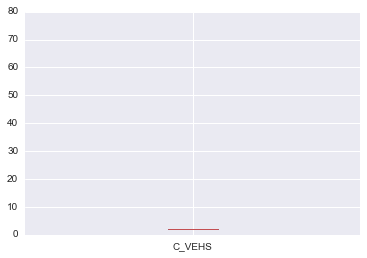

In [37]:
df_int[['C_VEHS']].boxplot()

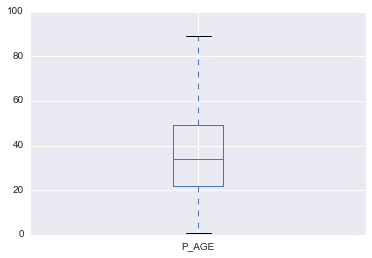

In [38]:
df_int[['P_AGE']].boxplot()

In [39]:
df_b = df.copy()
df_b['fatal']=np.where(df_b['P_ISEV'] == '3',1,0)
df_b['injury']=np.where(df_b['P_ISEV'] == '2',1,0)
df_b['no_injury']=np.where(df_b['P_ISEV'] == '1',1,0)

df1 = df_b.groupby('C_YEAR')['fatal','injury', 'no_injury'].sum()
df1

,fatal,injury,no_injury
C_YEAR,,,
1999,0,0,0
2000,0,0,0
2001,0,0,0
2002,0,0,0
2003,0,0,0
2004,0,0,0
2005,0,0,0
2006,0,0,0
2007,0,0,0


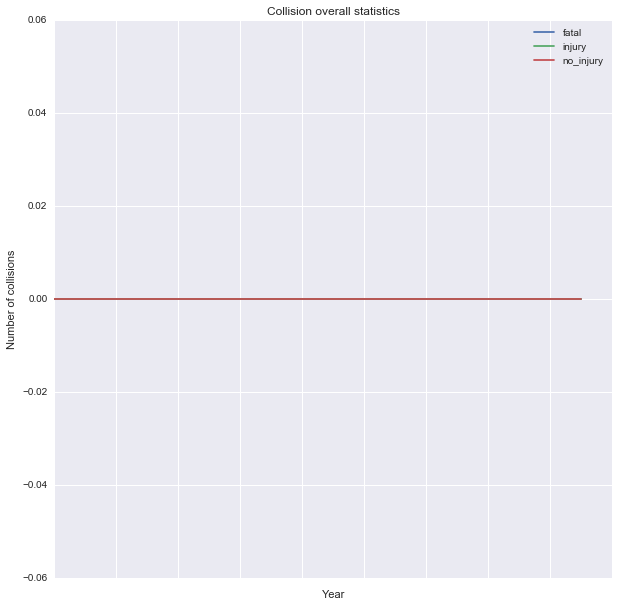

In [40]:
#The overall diagram
plot1 = df1.plot(figsize=(10,10),title='Collision overall statistics')
plot1.set_xlabel("Year")
plot1.set_ylabel("Number of collisions");

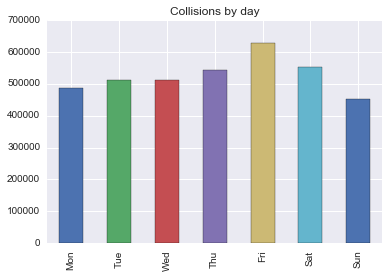

In [41]:
#Collisions by weekday
by_weekday = df_b.groupby('C_WDAY')['P_ISEV'].count()
by_weekday.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plot2 = by_weekday.plot(kind='bar',title='Collisions by day');

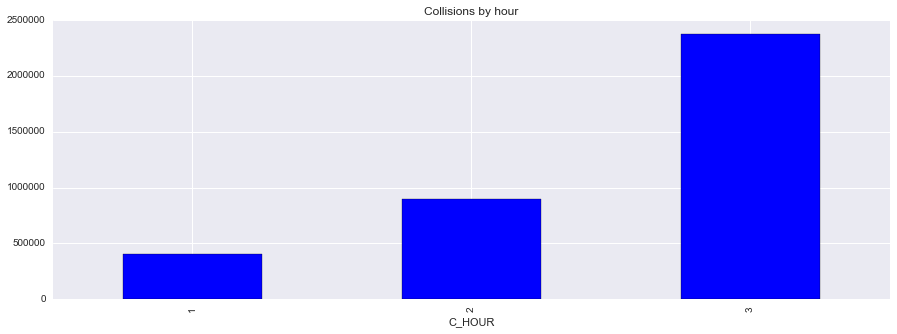

In [42]:
#Collisions by hour
plt.figure(figsize=(15,5))
by_hour = df_b.groupby('C_HOUR')['P_ISEV'].count()
plot3 = by_hour.plot(kind='bar',title='Collisions by hour',color='B');

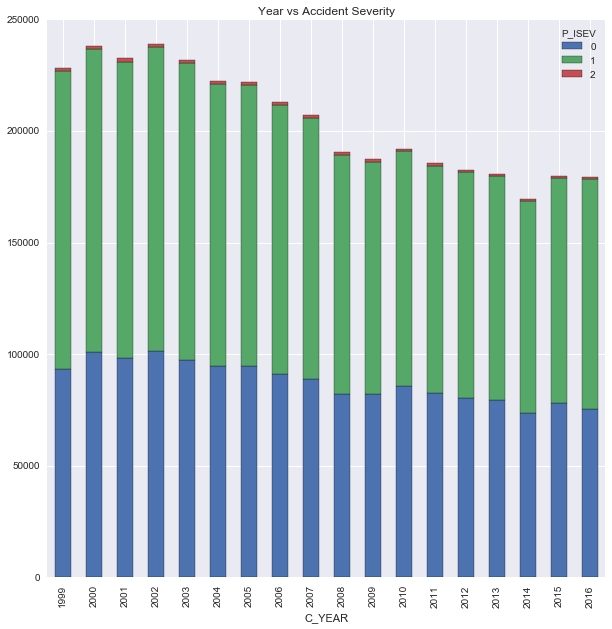

In [43]:
#Year vs Severity
df.groupby(['C_YEAR', 'P_ISEV']).size().unstack().plot(figsize=(10,10), kind='bar', title = 'Year vs Accident Severity', stacked = True)

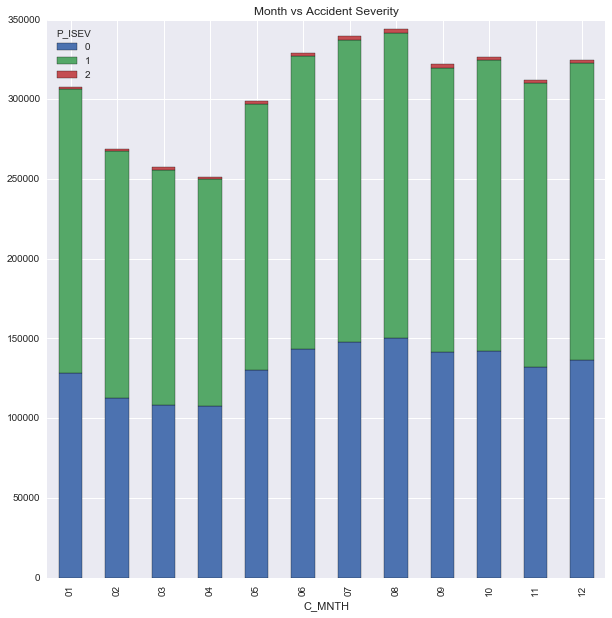

In [44]:
#Year vs Severity
df.groupby(['C_MNTH', 'P_ISEV']).size().unstack().plot(figsize=(10,10), kind='bar', title = 'Month vs Accident Severity', stacked = True)

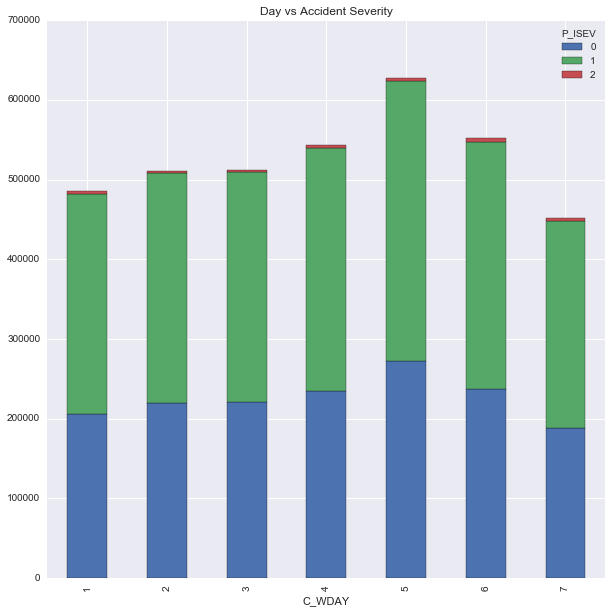

In [45]:
#Year vs Severity
df.groupby(['C_WDAY', 'P_ISEV']).size().unstack().plot(figsize=(10,10), kind='bar', title = 'Day vs Accident Severity', stacked = True)

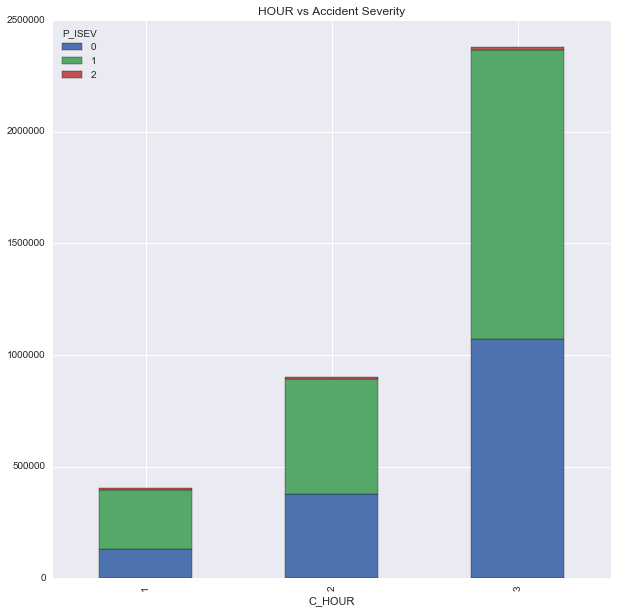

In [46]:
#Year vs Severity
df.groupby(['C_HOUR', 'P_ISEV']).size().unstack().plot(figsize=(10,10), kind='bar', title = 'HOUR vs Accident Severity', stacked = True)

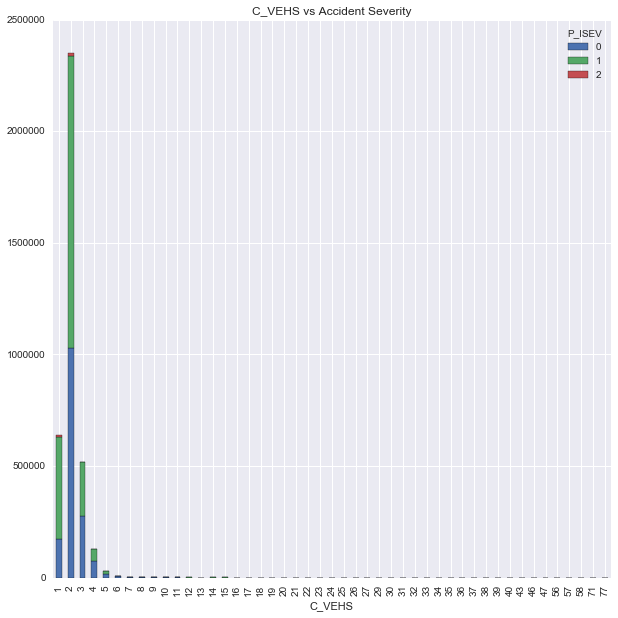

In [47]:
#Year vs Severity
df.groupby(['C_VEHS', 'P_ISEV']).size().unstack().plot(figsize=(10,10), kind='bar', title = 'C_VEHS vs Accident Severity', stacked = True)

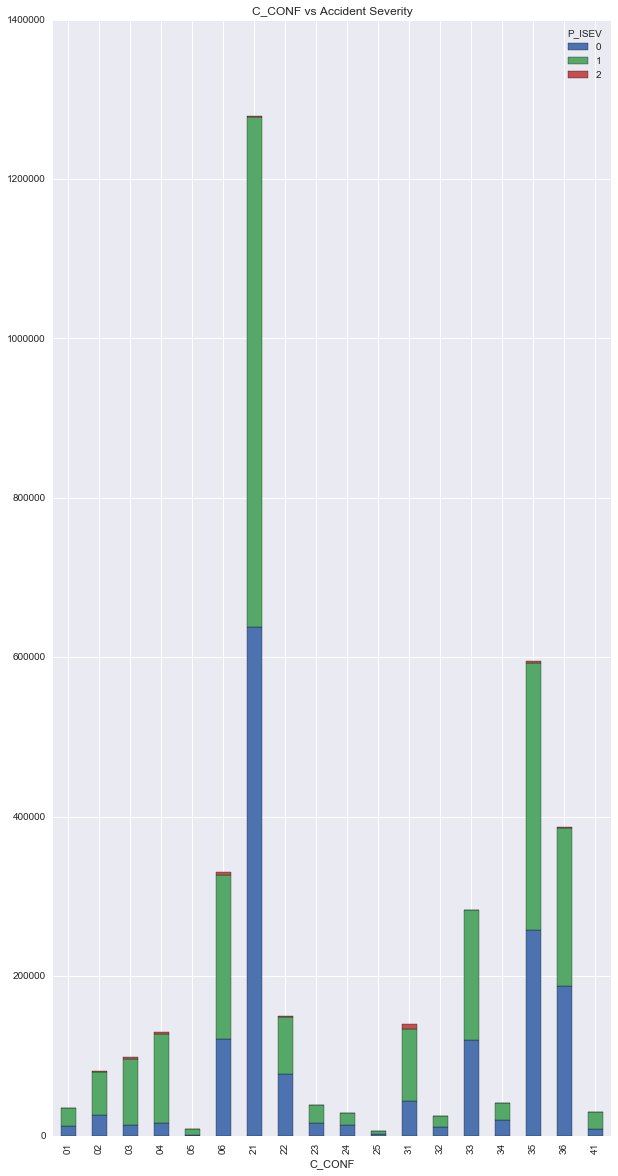

In [48]:
#Year vs Severity
df.groupby(['C_CONF', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'C_CONF vs Accident Severity', stacked = True)

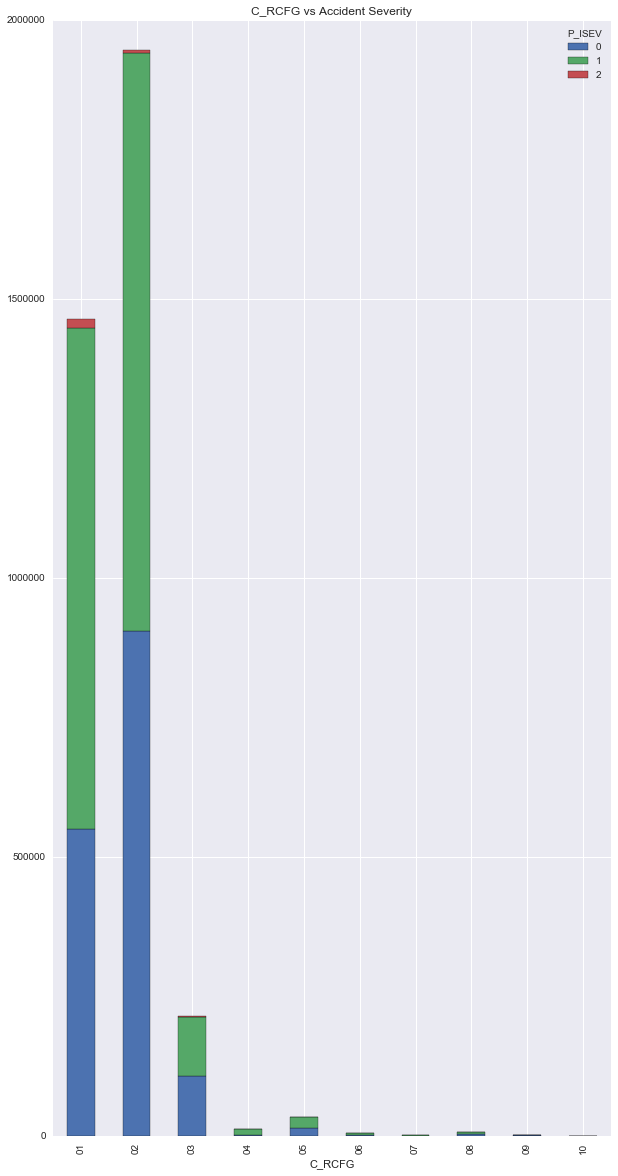

In [49]:
#Year vs Severity
df.groupby(['C_RCFG', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'C_RCFG vs Accident Severity', stacked = True)

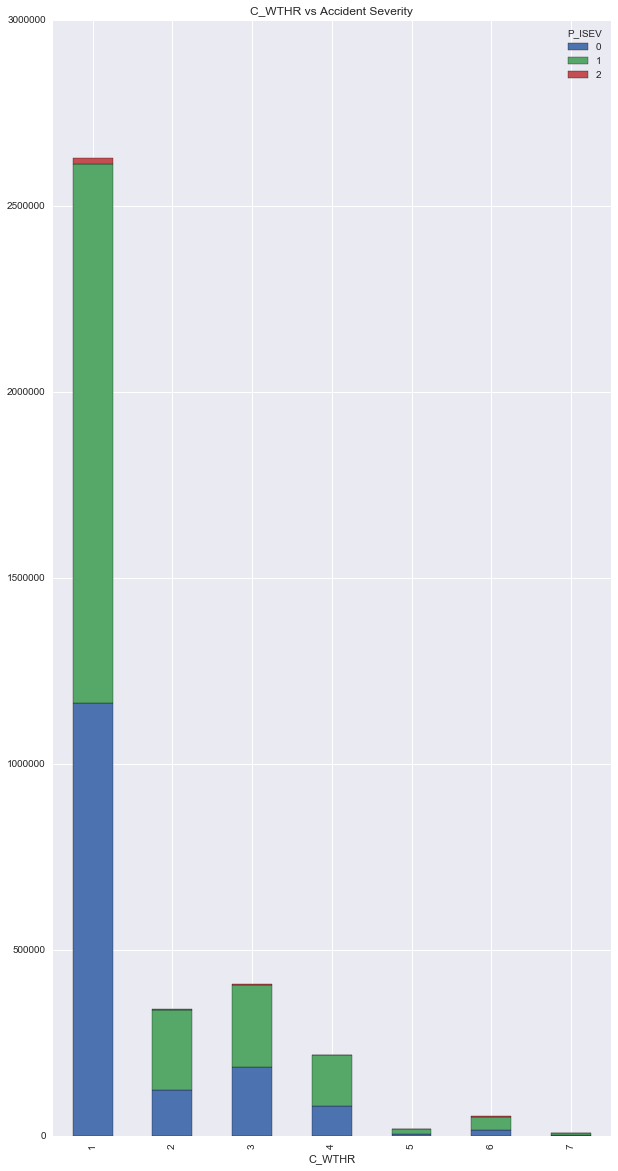

In [50]:
#Year vs Severity
df.groupby(['C_WTHR', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'C_WTHR vs Accident Severity', stacked = True)

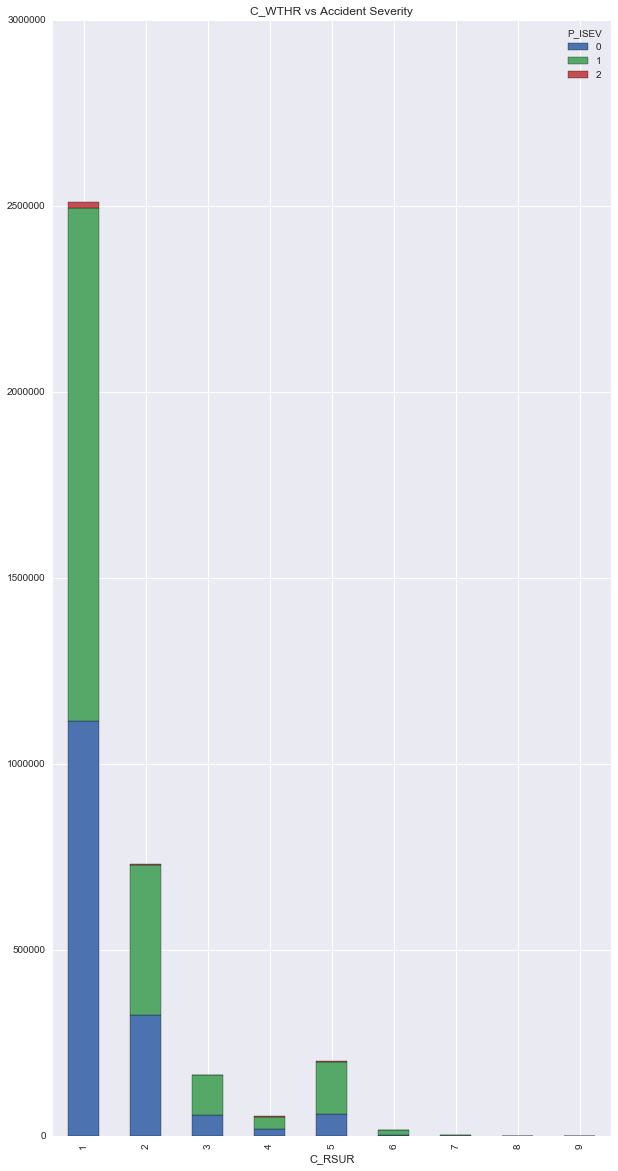

In [51]:
#Year vs Severity
df.groupby(['C_RSUR', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'C_WTHR vs Accident Severity', stacked = True)

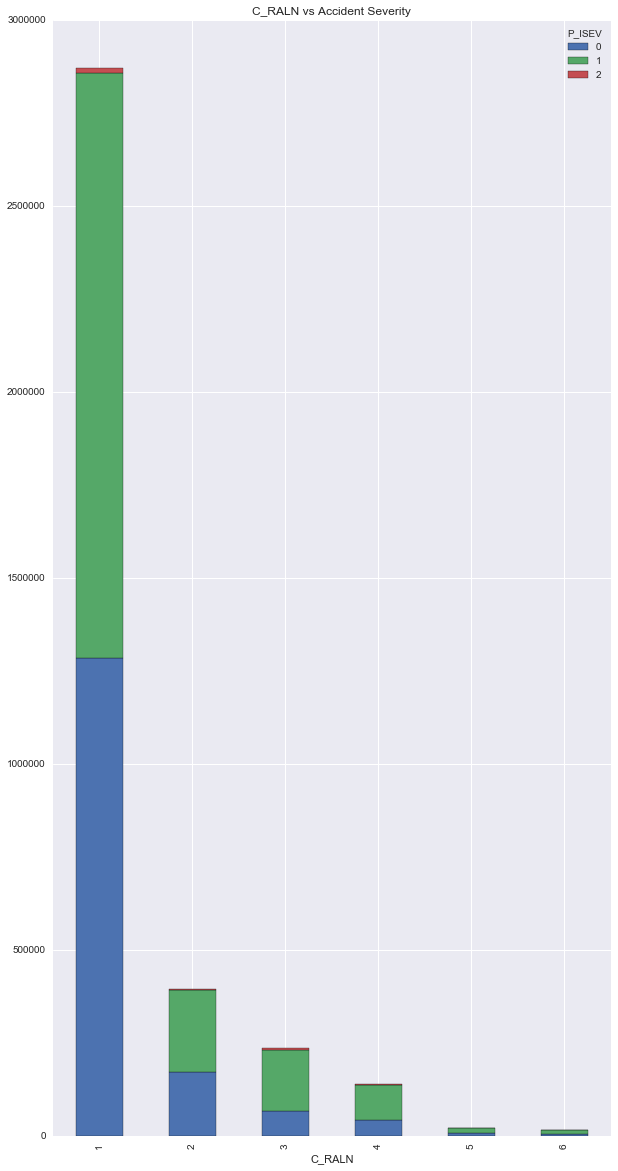

In [52]:
#Year vs Severity
df.groupby(['C_RALN', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'C_RALN vs Accident Severity', stacked = True)

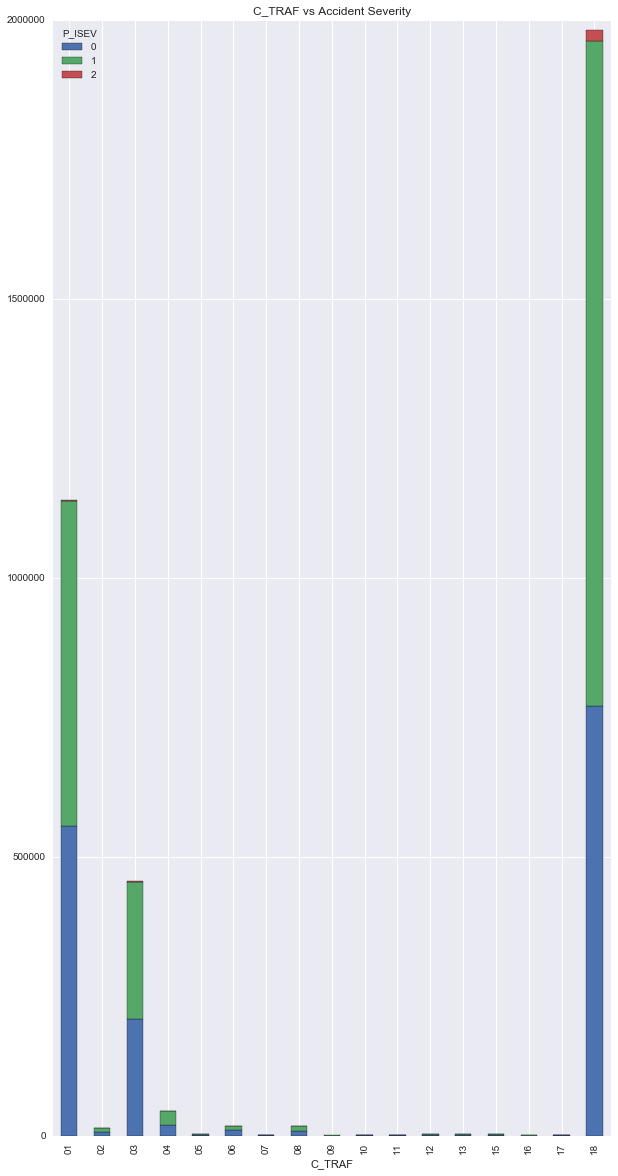

In [53]:
#Year vs Severity
df.groupby(['C_TRAF', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'C_TRAF vs Accident Severity', stacked = True)

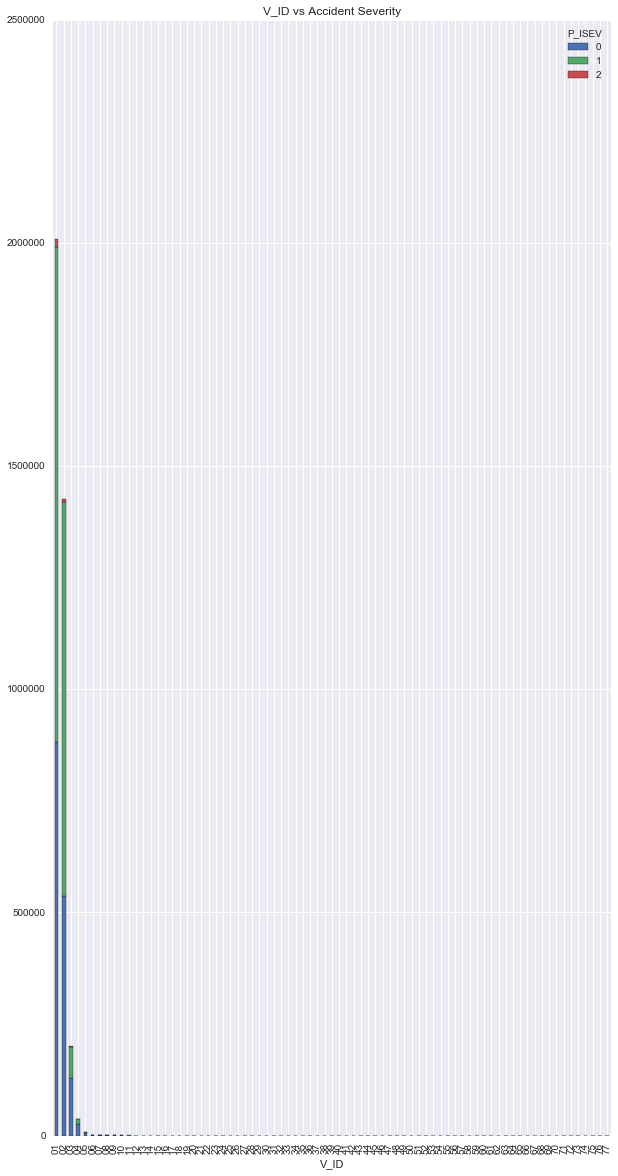

In [54]:
#Year vs Severity
df.groupby(['V_ID', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'V_ID vs Accident Severity', stacked = True)

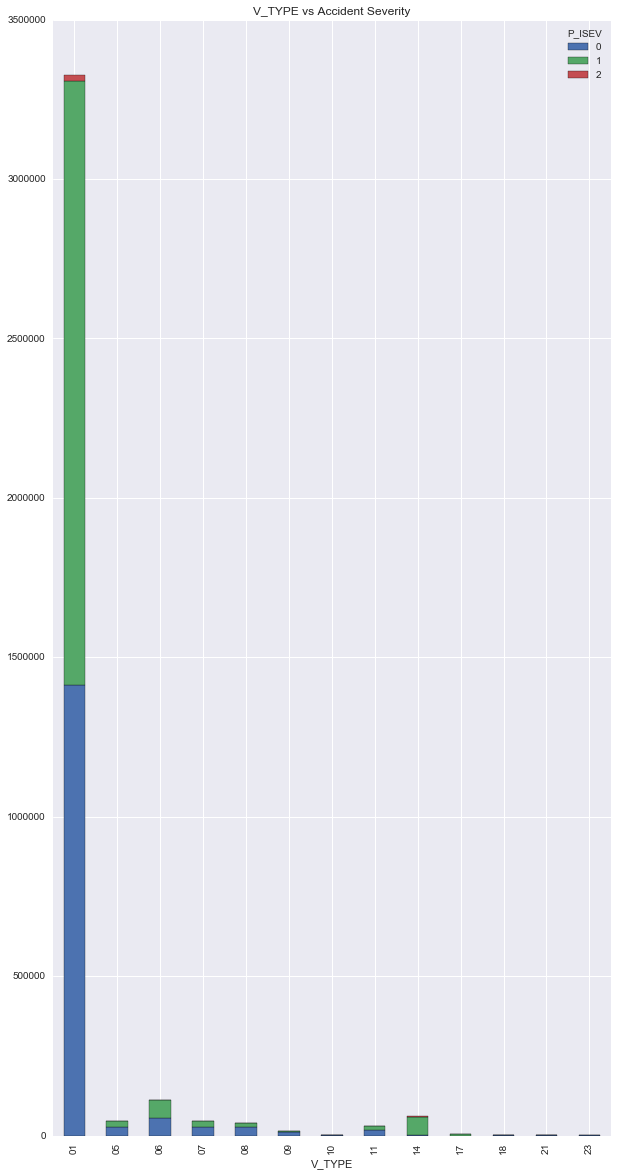

In [55]:
#Year vs Severity
df.groupby(['V_TYPE', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'V_TYPE vs Accident Severity', stacked = True)

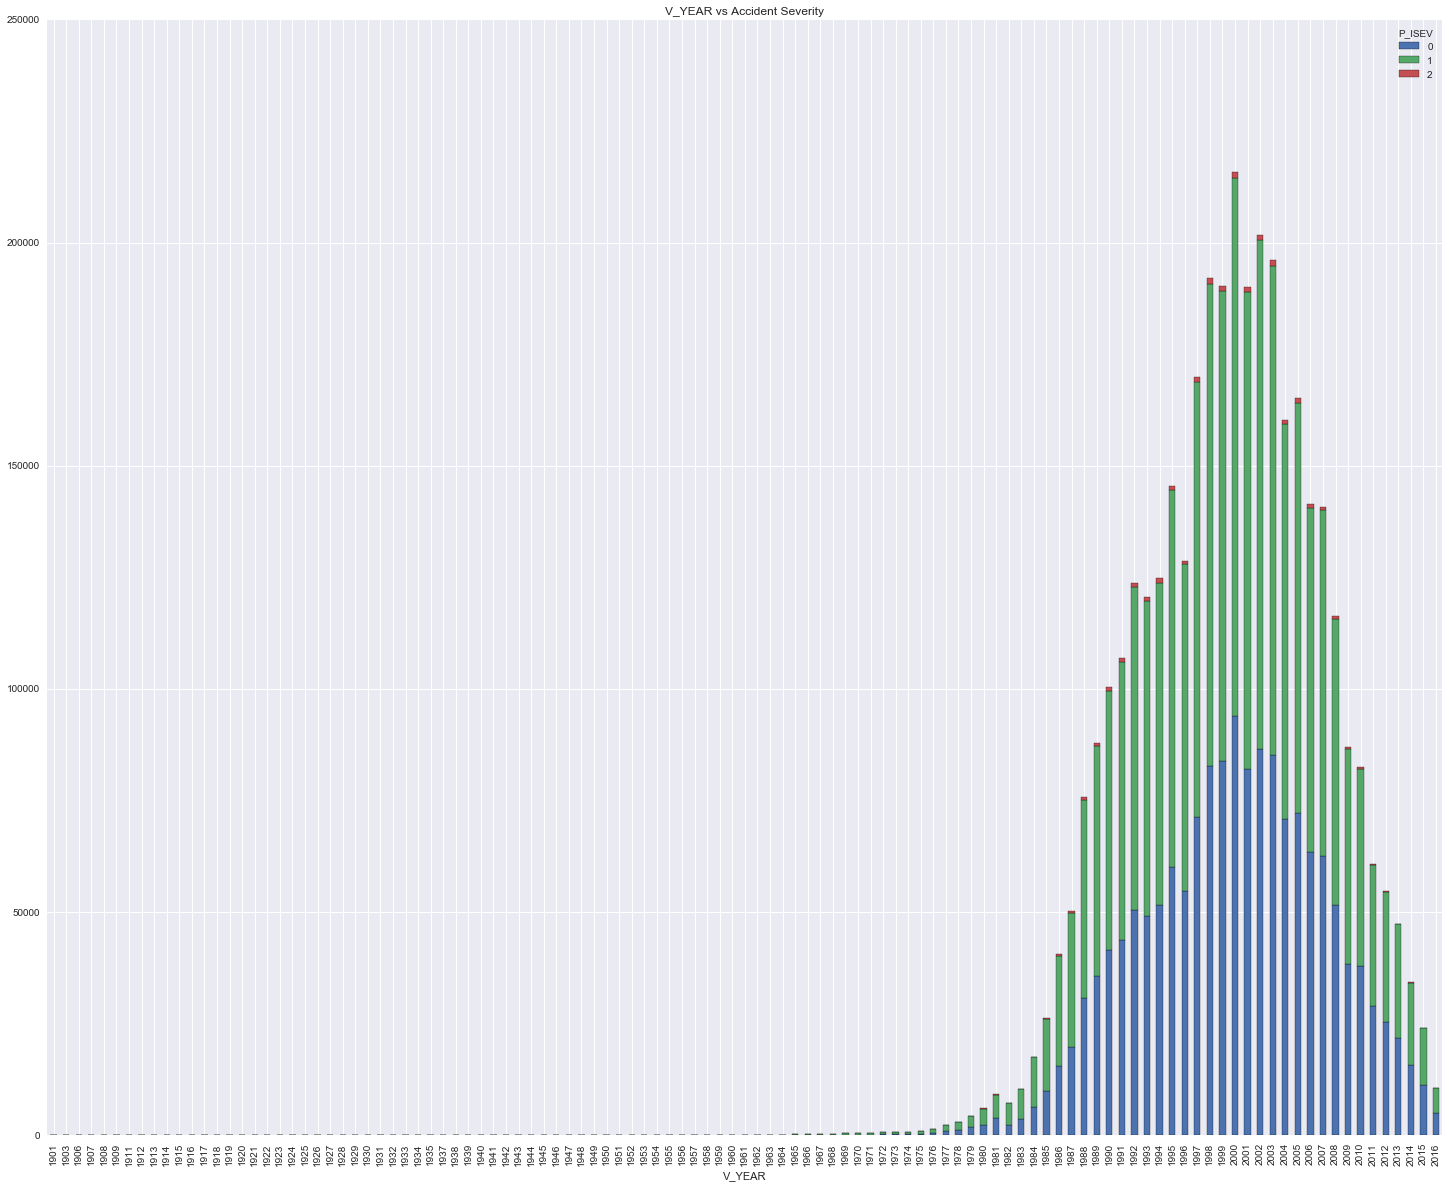

In [56]:
#Year vs Severity
df.groupby(['V_YEAR', 'P_ISEV']).size().unstack().plot(figsize=(25,20), kind='bar', title = 'V_YEAR vs Accident Severity', stacked = True)

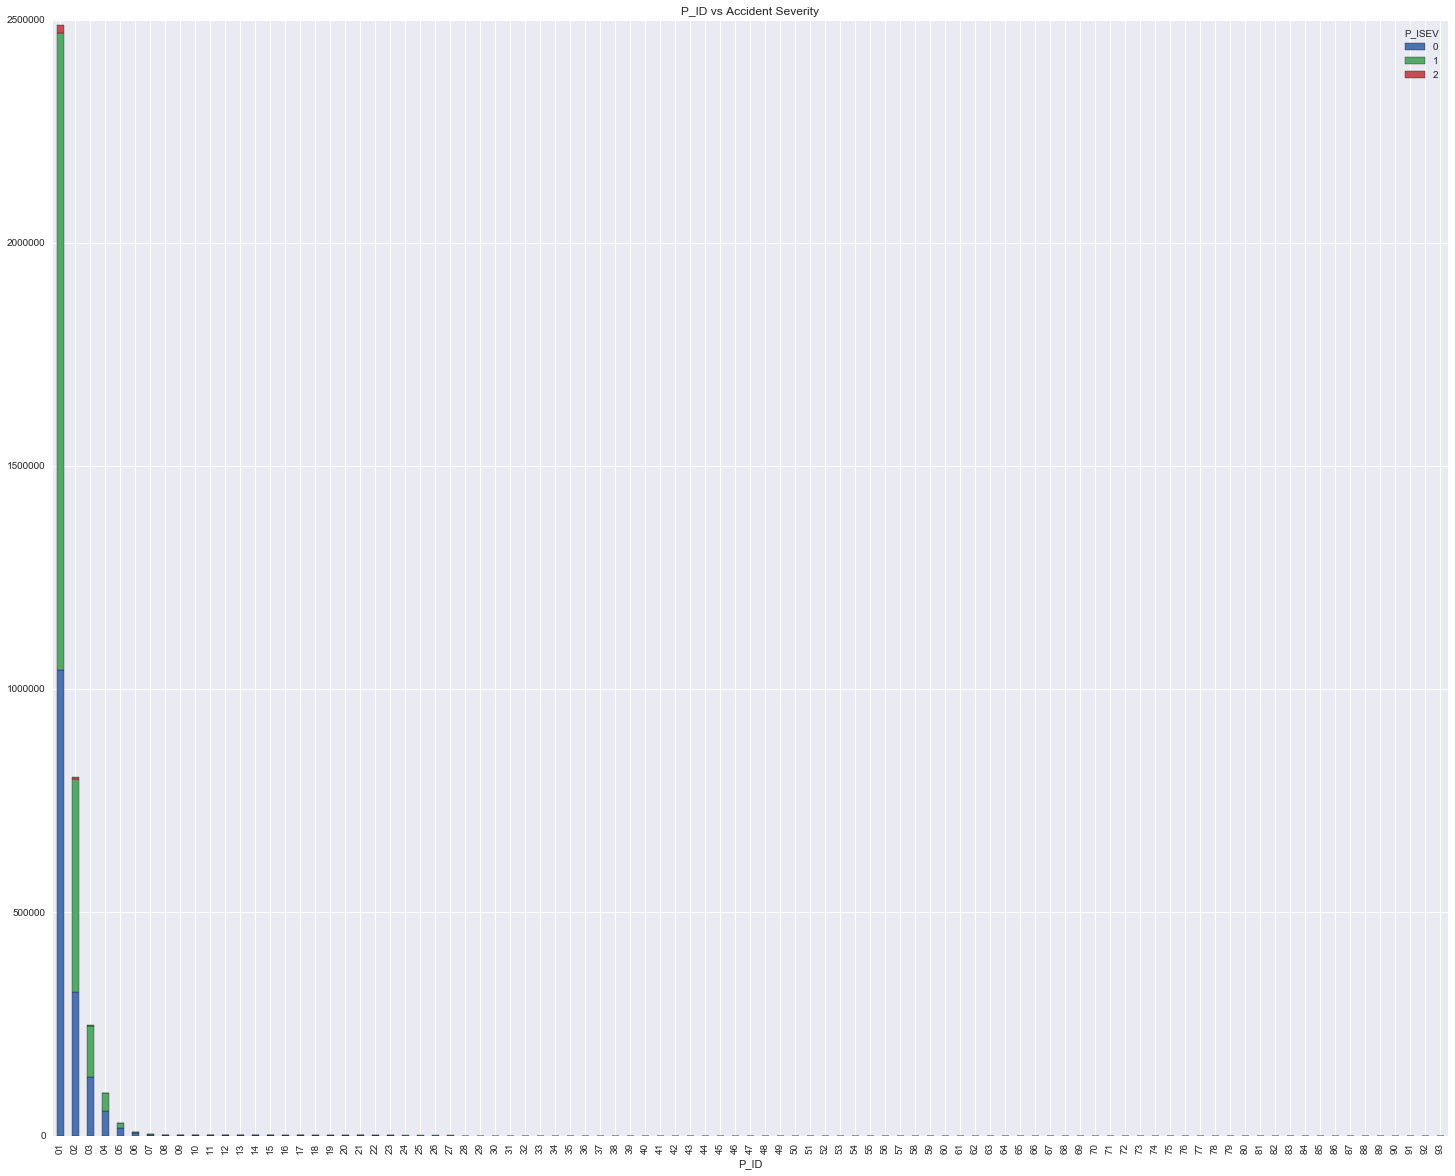

In [57]:
#Year vs Severity
df.groupby(['P_ID', 'P_ISEV']).size().unstack().plot(figsize=(25,20), kind='bar', title = 'P_ID vs Accident Severity', stacked = True)

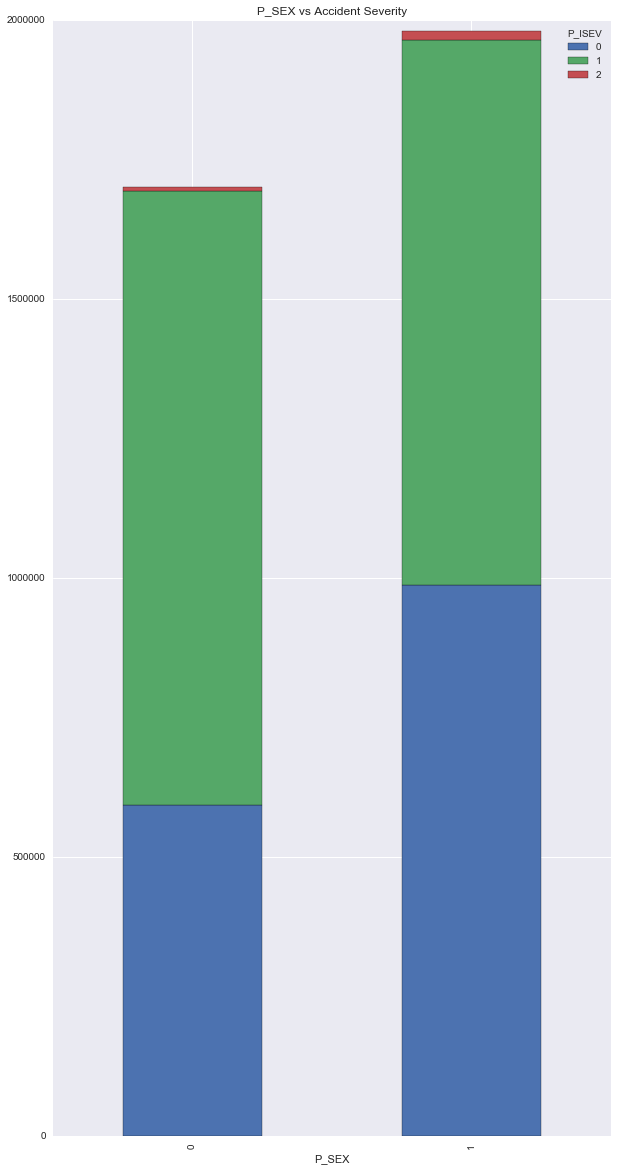

In [58]:
#Year vs Severity
df.groupby(['P_SEX', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'P_SEX vs Accident Severity', stacked = True)

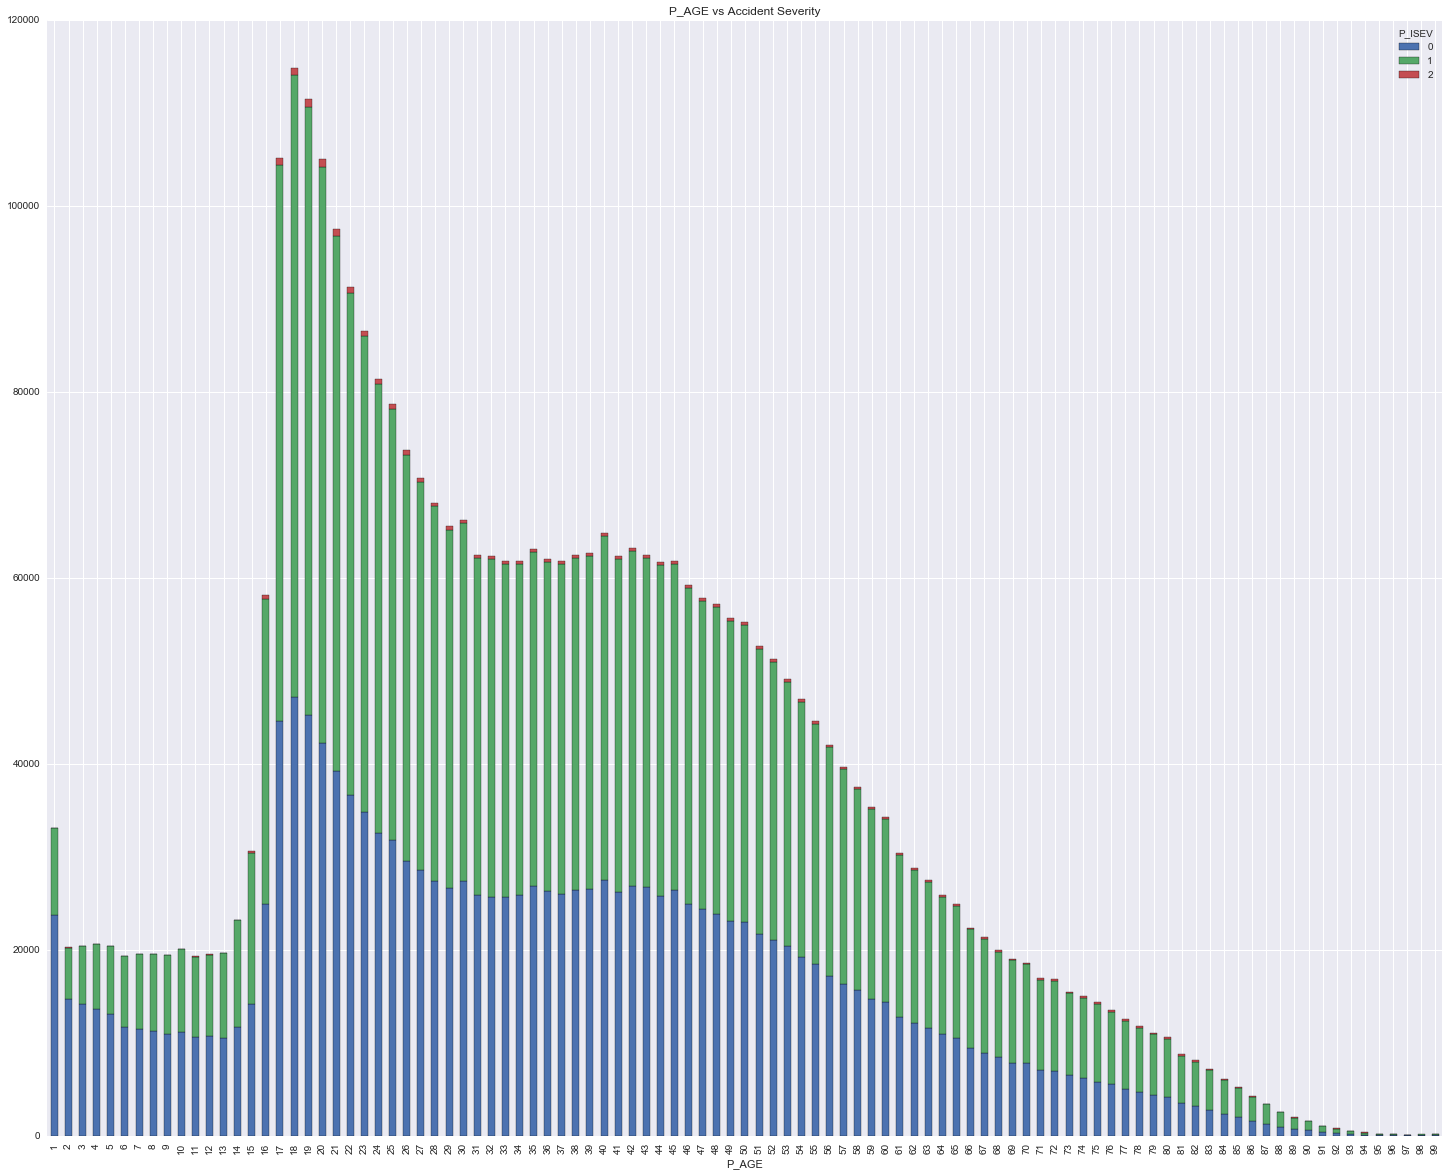

In [59]:
#Year vs Severity
df.groupby(['P_AGE', 'P_ISEV']).size().unstack().plot(figsize=(25,20), kind='bar', title = 'P_AGE vs Accident Severity', stacked = True)

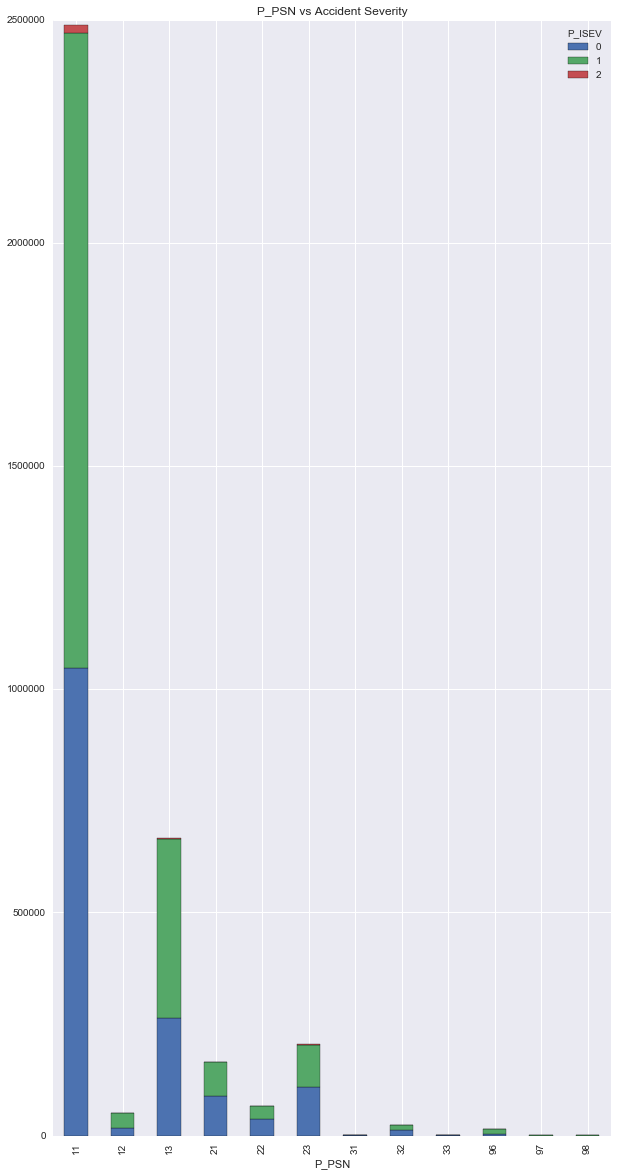

In [60]:
#Year vs Severity
df.groupby(['P_PSN', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'P_PSN vs Accident Severity', stacked = True)

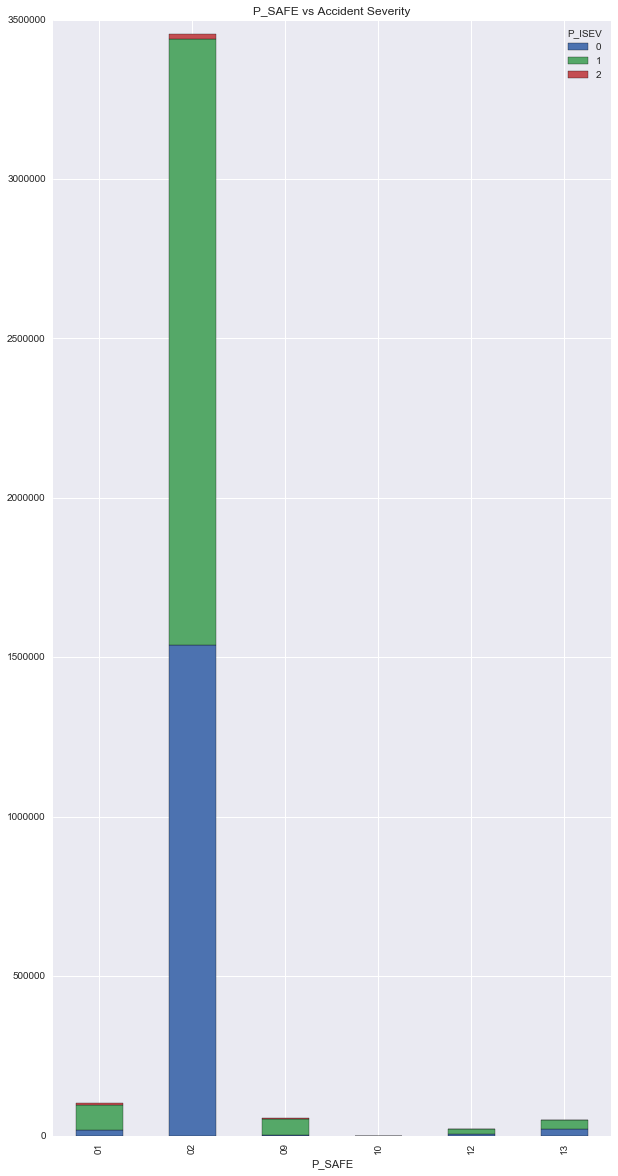

In [61]:
#Year vs Severity
df.groupby(['P_SAFE', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'P_SAFE vs Accident Severity', stacked = True)

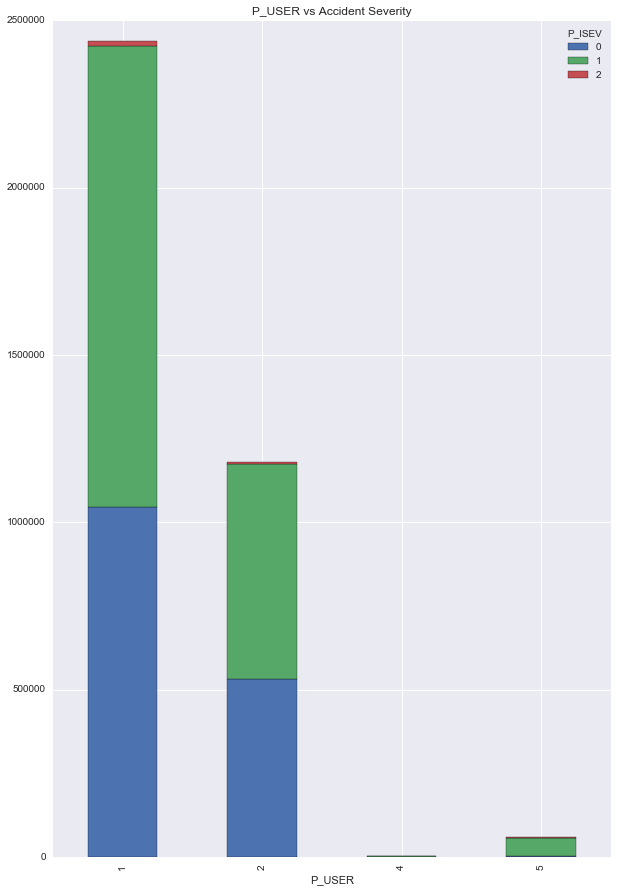

In [62]:
#Year vs Severity
df.groupby(['P_USER', 'P_ISEV']).size().unstack().plot(figsize=(10,15), kind='bar', title = 'P_USER vs Accident Severity', stacked = True)

In [63]:
#Year vs Severity
df.groupby(['P_ISEV', 'P_ISEV']).size().unstack().plot(figsize=(8,10), kind='bar', title = 'P_ISEV vs Accident Severity', stacked = True)

ValueError: Duplicated level name: "P_ISEV", assigned to level 1, is already used for level 0.

In [ ]:
#sns.pairplot(df_cat, hue='P_ISEV', size=2.5);
#sns.pairplot(df_cat, hue='P_ISEV')

for i, col in enumerate(df.columns):
    print(df[col].value_counts())

In [ ]:
%matplotlib inline
df_int[['C_VEHS', 'P_AGE']].boxplot()

In [ ]:
#check if dataset contains nulls
if df.isnull().sum().sum():
    print("Dataset contains Null values")
else:
    print("No Null values in the Dataset")

In [ ]:
if df.isna().sum().sum():
    print("Dataset contains missing values")
else:
    print("No missing values in the Dataset")

In [ ]:
df_cat['C_YEAR']

In [ ]:
df.index[df.isin(['U', 'UU', 'UUU', 'UUUU']).sum(axis=1) >= 3]

In [ ]:
#fataility stat by year

df.groupby('C_YEAR')['C_SEV'].count()

In [ ]:
df.describe()

### inspect the data types as imported

In [ ]:
df.dtypes

In [ ]:
#select multiple column
df[['C_YEAR', 'C_MNTH']]

In [ ]:
#df['name_match'] = df['First_name'].apply(lambda x: 'match' if x == 'Bill' else 'Mis-match')
#df['N_ISEV'] = df['P_ISEV'].apply(lambda x: 'NON_FATAL' if x in ['1', '2', 'N'] else 'FATAL' if x in ['2'] else float('NaN'))
df['N_ISEV'] = df['P_ISEV'].apply(lambda x: 'NON_FATAL' if x in ['1', '2', 'N'] else 'FATAL' if x in ['2'] else np.nan)

In [ ]:
df[['P_ISEV','N_ISEV']]

In [ ]:
df

In [ ]:
#drop a column axis=1 drop column, axis=0 drop row
df.drop('N_ISEV', axis=1, inplace=True)

In [ ]:
#selecting rows or df.iloc[0]
df.loc[0]

In [ ]:
#select elements greater than 0
df[df>0]
df>0

In [ ]:
#get fatal collisions, get rows that are true for condition below
df[df['P_ISEV'] == '3']

In [ ]:
#get fatal and injury
df[(df['P_ISEV'] == '2') | (df['P_ISEV'] == '3')]

In [ ]:
#drop columns with na values where thresh number of columns is not NaN 
df.dropna(axis=1, thresh = 20)

In [ ]:
#fill na
df.fillna(value='Fill Value')

In [ ]:
#work on column only and replace na with mean
df['C_YEAR'].fillna(value=df['C_YEAR'].mean())

In [ ]:
#group by
#df.groupby('V_YEAR').count()
#df.groupby('V_YEAR')['P_ISEV'].count()
df.groupby('V_YEAR')['P_ISEV'].count().loc['2013']

In [ ]:
#5 level summary
#df.groupby('V_YEAR').describe().transpose()
df.groupby('V_YEAR').describe()